# AI Working Group
#### 10/8/18

In [1]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, Image
from IPython.core.display import display, HTML
import random
import math
np.random.seed(1212)
import tensorflow as tf
tf.test.gpu_device_name()

'/gpu:0'

### Entropy Optimization

Without making assumptions on the functional form of the probability distribution of the credit portfolio, one can maximize the entropy, i.e.,

$\max{(-\sum_{k=1}^{n_{k}} p_{k} \log{p_{k}})}$

conditional on the following constaints:

$\sum_{k=1}^{n_{k}} p_{k} = 1$,

$\sum_{k=1}^{n_k} \mathbb{1}_{kj} p_{k} u_{k} = \mathbb{E}[\text{Loss}_j] = \epsilon_j$, $j \in (1,...,n_k)$,

where

$\mathbb{1}_{kj} = \begin{cases} 1 & \text{if } k \leq j \text{,}\\ 0 & \text{otherwise} \end{cases}$

and

$\epsilon_j = \sum_{k=1}^{n_{k}} u_k (1 - q_j)$, $j \in (1,...,n_k)$.

It can be proven that the entropy function is a concave function with a well defined maximum. From here we write the Lagrangian:

$\mathscr{L} = - \sum_{k=1}^{n_{k}} p_{k} \log{p_{k}} + (\lambda_0 + 1) (\sum_{k=1}^{n_{k}} p_{k} - 1) + \sum_{j \in (1,...,n_k)} \lambda_j (\sum_{k=1}^{n_{k}} \mathbb{1}_{kj} (p_{k} u_{k} - \epsilon_j)$,

In order to maximize the entropy, now make:

$\frac{\partial\mathscr{L}}{\partial p_{k}} = - \log{p_{k}} - 1 + \lambda_0 + 1 + \sum_{j \in (1,...,n_k)} \lambda_j u_{k} \mathbb{1}_{kj} = 0 \Longrightarrow p_k = \exp{(-\lambda_0 - \sum_{j \in (1,...,n_k)} \lambda_j u_{k} \mathbb{1}_{kj})}$.

Applying the first constrain:

$\sum_{k=1}^{n_{k}} p_{k} = 1 \Longrightarrow \sum_{k=1}^{n_{k}} \exp{(-\lambda_0 - \sum_{j \in (1,...,n_k)} \lambda_j u_{k} \mathbb{1}_{kj})} = 1 \Longrightarrow$

$\exp{\lambda_0} = \sum_{k=1}^{n_{k}} \exp{(- \sum_{j \in (1,...,n_k)} \lambda_j u_{k} \mathbb{1}_{kj})}$

Applying this back to $p_k$:

$p_k = \frac{\exp{(- \sum_{j \in (1,...,n_k)} \lambda_j u_{k} \mathbb{1}_{kj})}}{\sum_{k=1}^{n_{k}} \exp{(- \sum_{j \in (1,...,n_k)} \lambda_j u_{k} \mathbb{1}_{kj})}}$

This can now be applied back to the second set of constraints, the ones for the expected losses accross different subordinations of the portfolio:

$\sum_{k=1}^{n_k} \mathbb{1}_{kj} p_{k} u_{k} - \epsilon_j = 0 \Longrightarrow \sum_{k=1}^{n_k} \mathbb{1}_{kj} u_{k} \frac{\exp{(- \sum_{j \in (1,...,n_k)} \lambda_j u_{k} \mathbb{1}_{kj})}}{\sum_{k=1}^{n_{k}} \exp{(- \sum_{j \in (1,...,n_k)} \lambda_j u_{k} \mathbb{1}_{kj})}} - \epsilon_j = 0 \Longrightarrow$

$\sum_{k=1}^{n_k} (\mathbb{1}_{kj} u_k - \epsilon_j) \exp{(- \sum_{j \in (1,...,n_k)} \lambda_j u_{k} \mathbb{1}_{kj})} = 0$

Note that there are $j \in (1,...,n_k)$ equations, but we have this number plus $n_k$ unknowns given $u_k$. The system is underspecified and thus the minimization of a cost function is more appropriate.

Now if one applies $p_k$ to the Lagrangian $\mathscr{L}$, after some algebraic manipulation, it can be demonstrated that the cost function is the Lagrangian written as:

$\mathscr{L} = \log{[\sum_{k=1}^{n_k} \exp{(- \sum_{j \in (1,...,n_k)} \lambda_j u_k \mathbb{1}_{kj})}]} - \sum_{j \in (1,...,n_k)} \lambda_j \epsilon_j$

---

### Parameter Calibration

Now that we do have a function to minimize, the parameters $\lambda_j$ and $u_k$ can be calibrated with Markov Chain Monte Carlo techniques such as Gibbs Sampling or Metropolis-Hastings. These techniques are well described here:

https://www.coursera.org/lecture/bayesian-methods-in-machine-learning/gibbs-sampling-eZBy5

---

### Steps

(1) Calibrate the expected losses by subordination (Section D of the paper below) and by maturity (3Y, 5Y, etc), using the whole population (no industry/region cohorts).

http://jive.ms.com/docs/DOC-253898

(2) Calibrate parameters $\lambda_j$ and $u_k$  for the whole credit population as described previuosly. The result is a loss probability distribution for the whole credit population.

(3) Adjust the loss probability distribution in (2) for each granular cohort (industry, region, etc) through the minimization of the relative entropy, using the loss probability distribution in (2) as prior distribution and the expected loss constraints of the specific cohort population.

(4) Compute the credit spreads for each cohort given the specific cohort loss distributions.

---

### Example of Metropolis-Hastings with TensorFlow

Below is an example of an implementation of Metropolis-Hastings in TensorFlow. This is an implementation with Simulated Annealing, here are some references:

http://rbanchs.com/documents/THFEL_PR15.pdf

https://am207.github.io/2017/wiki/lab4.html

In [2]:
tf.reset_default_graph()
# Define objective function
def fx(x):
    #return tf.sin(1.5*x)+0.5*x-0.025*x**2-tf.cos(2.5*x)+1
    return tf.sin(2*x)+0.5*x-0.025*x**2-tf.cos(1.8*x)+1
# Define temperature fractional reduction
def fractional_reduction(prob_0,prob_50,n_cycles):
    t0 = -1.0/math.log(prob_0) # Initial temperature, prob_0 = Probability of accepting worse solution at the start
    t50 = -1.0/math.log(prob_50) # Final temperature, prob_50 = Probability of accepting worse solution at the end
    return (t50/t0)**(1.0/(n_cycles-1.0)) # Fractional reduction every cycle

In [3]:
# Define and initializing variables
n = 1000 # Number of cycles
m = 50 # Reannealing interval
pm = 0.01
p0 = 0.7
anneal = fractional_reduction(p0,pm,n//m) # Reannealing constant

# Define and initialize TensorFlow graph
x = tf.Variable(4.)
x_value = tf.placeholder(dtype=tf.float32)
x_assign = x.assign(x_value)
e_x = fx(x)

# Minimizing with SGD-type optimizer
#train_op_x = tf.train.GradientDescentOptimizer(0.01).minimize(e_x)
train_op_x = tf.train.AdamOptimizer(0.01).minimize(e_x)

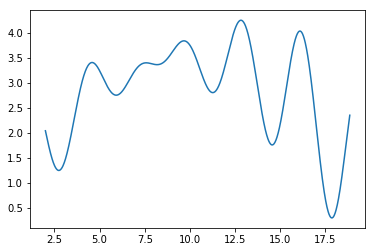

In [4]:
j = n
x_ = np.linspace(2,6*math.pi,j)
e_ = np.empty((0))
with tf.Session() as s:
    s.run(tf.global_variables_initializer())
    for i in range(j):
        e_ = np.append(e_,s.run(e_x,feed_dict={x:x_[i]}))
plt.plot(x_,e_)

In [5]:
# Initialize run
xi = np.random.normal(0,np.std(x_),n+1)
ei = np.zeros(n+1)
em = np.zeros(n+1)
#h = np.zeros(n+1)
i = 0
j = 0
t = -1.0/math.log(p0)
e_tol = 1E-4

In [6]:
session = tf.Session()
with session as s:
    s.run(tf.global_variables_initializer())
    xi[i] = x.eval()
    s.run(x_assign,feed_dict={x_value:xi[0]}) # Random noise
    ei[i] = s.run(e_x) # Initial energy
    em[i] = ei[i] # Running energy average
    em0 = em[i]
    hm = np.empty((0))
    h = 0
    print('Initial state: x0={}, e0={}, t={}'.format(xi[i],ei[i],t))
    while i < n:
        i = i+1
        xi[i] = max(min(xi[i-1]+xi[i],6*math.pi),2) # Random noise
        s.run(x_assign,feed_dict={x_value:xi[i]})
        ei[i] = s.run(e_x)
        if ei[i] < ei[i-1]: # Better solution, automatic acceptance
            accept = True
        else: # Worse solution
            p = np.exp(-abs(ei[i]-ei[i-1])/(em[i-1]*t))
            if random.random() < p: # Can solution still be accepted?
                accept = True
            else:
                accept = False
        if accept:
            j = j+1 # Number of accepted solutions
            em[i] = (em[i-1]*(j-1.0)+abs(ei[i]-ei[i-1]))/j # Compute running energy average
            h = h+ei[i]*np.exp(-ei[i]/(em[i]*t))/(em[i]*t) # Compute entropy
        else:
            xi[i] = xi[i-1]
            s.run(x_assign,feed_dict={x_value:xi[i]})
            ei[i] = ei[i-1]
            em[i] = em[i-1]
        if i % m == 0:
            print('i={}, x0={}, xi={}, e0={}, ei={}, em={}, p={}, t={}, j={}'.format(i,xi[i-1],xi[i],ei[i-1],ei[i],em[i],p,t,j))
            hm = np.append(hm,h)
            h = 0
            t = anneal*t # Reannealing, lower the temperature for next cycle
            if abs(em[i]-em0) < e_tol:
                break
            em0 = em[i]
    e0 = 0
    print('Before SGD: xi = {}, ei ={}'.format(x.eval(),s.run(e_x)))
    while abs(ei[i]-e0)>=e_tol:
        s.run(train_op_x)
        e0 = ei[i]
        ei[i] = s.run(e_x)
        print('SGD: xi={}, ei={}'.format(x.eval(),s.run(e_x)))
    xi[i] = x.eval()
    print('Final state: xi={}, ei={}'.format(x.eval(),s.run(e_x)))
session.close()

Initial state: x0=4.0, e0=2.981006622314453, t=2.8036732520571284
i=50, x0=3.539030367257472, xi=2.0, e0=2.1739611625671387, ei=2.0399560928344727, em=0.29388701575142995, p=0.8543249352846649, t=2.8036732520571284, j=35
i=100, x0=2.4591463969731615, xi=2.4591463969731615, e0=1.3815571069717407, ei=1.3815571069717407, em=0.3063161313533783, p=0.4159748899131485, t=2.4505023923427123, j=60
i=150, x0=2.3553534141003483, xi=2.3553534141003483, e0=1.4943249225616455, ei=1.4943249225616455, em=0.3558779444013324, p=0.10376912808919325, t=2.1418194757436013, j=84
i=200, x0=2.0, xi=2.0, e0=2.0399560928344727, ei=2.0399560928344727, em=0.3879214869095729, p=0.15665023379845222, t=1.8720204807835303, j=104
i=250, x0=14.751840882859902, xi=17.06732367939687, e0=1.843569040298462, ei=1.893487811088562, em=0.3601237929982247, p=0.9192546517294002, t=1.6362073088612261, j=139
i=300, x0=18.334694759836317, xi=18.376945928571168, e0=0.9218906164169312, ei=1.0266942977905273, em=0.3614402635563054, p=

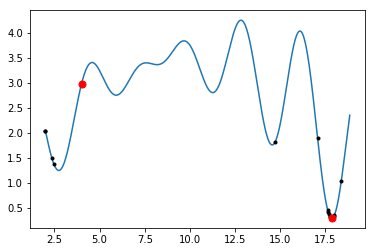

In [7]:
# Energy function and convergence
plt.plot(x_,e_)
j = i//m
xx = np.empty((0))
ee = np.empty((0))
for k in range(i+1):
    if k%m==0:
        xx = np.append(xx,xi[k])
        ee = np.append(ee,ei[k])
plt.plot(xx,ee,'ko',ms=3)
plt.plot(xx[0],ee[0],'ro',ms=7)
plt.plot(xx[j],ee[j],'ro',ms=7)